# Sequential Monte Carlo

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.9.1


In [2]:
az.style.use("arviz-darkgrid")

Sampling from distributions with multiple peaks with standard MCMC methods can be difficult, if not impossible, as the Markov chain often gets stuck in either of the minima. A Sequential Monte Carlo sampler (SMC) is a way to ameliorate this problem.

As there are many SMC flavors, in this notebook we will focus on the version implemented in PyMC3.

SMC combines several statistical ideas, including [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling), tempering and an MCMC kernel. By tempering we mean the use of an auxiliary _temperature_ parameter to control the sampling process. This is easy to see if we write the posterior as:

$$p(\theta \mid y)_{\beta} \propto p(y \mid \theta)^{\beta} \; p(\theta)$$

When $\beta=0$ we have that $p(\theta \mid y)_{\beta=0}$ is the prior distribution and when $\beta=1$ we recover the _true_ posterior. We can think of $\beta$ as a knob to gradually turn-on the likelihood. This can be useful as in general sampling from the prior is easier than sampling from the posterior distribution. Thus we can use $\beta$ to control the transition from an easy to sample distribution to a harder one.

A summary of the algorithm is:

1. Initialize $\beta$ at zero and `stage` at zero.
2. Sample from the prior a set of samples $S_{\beta}$ of size $N$. When $\beta = 0$ the tempered posterior is the prior.
3. Increase $\beta$ in order to make the effective sample size (ESS) equals some predefined value. We use $Nt$, where $t$ is the threshold parameter -- by default t=0.5. This means that the default ESS is fixed at half the number of draws.
4. Compute a set of $N$ importance weights $W$. The weights are computed as the ratio of the tempered likelihoods at stage $i+1$ and stage $i$.
5. Obtain a new set of samples $S_{w}$ by re-sampling $S_{\beta}$ according to $W$.
6. Use the $S_{w}$ to compute the covariance for (multivariate)normal proposal distribution.
7. For stages other than 0 use the acceptance rate from the previous stage to estimate the scaling of the proposal distribution and to compute `nsteps`.
8. Run $N$ Metropolis chains (each one of length `n_steps`), starting each one from a different sample $S_{w}$.
9. Repeat from step 3 until $\beta \ge 1$.
10. The final result is a collection of $N$ samples from the posterior.

The algorithm is summarized in the next figure, the first subplot shows 5 samples (orange dots) at some particular stage. The second subplot shows how these samples are reweighted according to their posterior density (blue Gaussian curve). The third subplot shows the result of running a certain number of Metropolis steps, starting from the reweighted samples $S_{w}$ in the second subplot, notice how the two samples with the lower posterior density (smaller circles) are discarded and not used to seed Markov chains.

![SMC stages](https://github.com/pymc-devs/pymc3/raw/master/docs/source/notebooks/smc.png)


SMC samplers can also be interpreted in the light of genetic algorithms, which are biologically-inspired algorithms that can be summarized as follows:

1. Initialization: set a population of individuals
2. Mutation: individuals are somehow modified or perturbed
3. Selection: individuals with high _fitness_ have higher chance to generate _offspring_.
4. Iterate by using individuals from 3 to set the population in 1.

If each _individual_ is a particular solution to a problem, then a genetic algorithm will eventually produce good solutions to that problem. One key aspect is to generate enough diversity (mutation step) in order to explore the solution space and hence avoiding getting trap in local minima. Then we perform a _selection_ step to _probabilistically_ keep reasonable solutions while also keeping some diversity. Being too greedy and short-sighted could be problematic, _bad_ solutions in a given moment could lead to _good_ solutions in the future.

For the SMC version implemented in PyMC3 we set the number of parallel Markov chains $N$ with the `draws` argument. At each stage SMC will use independent Markov chains to explore the _tempered posterior_ (the black arrow in the figure). The final samples, _i.e_ those stored in the `trace`, will be taken exclusively from the final stage ($\beta = 1$), i.e. the _true_ posterior ("true" in the mathematical sense).

The successive values of $\beta$ are determined automatically (step 3). The harder the distribution is to sample the closer two successive values of $\beta$ will be. And the larger the number of stages SMC will take. SMC computes the next $\beta$ value by keeping the effective sample size (ESS) between two stages at a constant predefined value of half the number of draws. This can be adjusted if necessary by the `threshold` parameter (in the interval [0, 1])-- the current default of 0.5 is generally considered as a good default. The larger this value, the higher the target ESS and the closer two successive values of $\beta$ will be. This ESS values are computed from the importance weights (step 4) and not from the autocorrelation like those from ArviZ (for example using `az.ess` or `az.summary`). 

Two more parameters that are automatically determined are:

* The number of steps each Markov chain takes to explore the _tempered posterior_ `n_steps`. This is determined from the acceptance rate from the previous stage.
* The (co)variance of the (Multivariate)Normal proposal distribution is also adjusted adaptively based on the  acceptance rate at each stage.

As with other sampling methods, running a sampler more than one time is useful to compute diagnostics, SMC is no exception. PyMC3 will try to run at least two **SMC chains** (do not confuse with the $N$ Markov chains inside each SMC chain).

Even when SMC uses the Metropolis-Hasting algorithm under the hood, it has several advantages over it:

* It can sample from distributions with multiple peaks.
* It does not have a burn-in period, it starts by sampling directly from the prior and then at each stage the starting points are already _approximately_ distributed according to the tempered posterior (due to the re-weighting step).
* It is inherently parallel (PyMC4 will take better advantage of this feature).

## Solving a PyMC3 model with SMC

To see an example of how to use SMC inside PyMC3 let's define a multivariate Gaussian of dimension $n$ with two modes, the weights of each mode and the covariance matrix. 

In [3]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1  # one mode with 0.1 of the mass
w2 = 1 - w1 # the other mode with 0.9 of the mass

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

In [4]:
with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    llk = pm.Potential("llk", two_gaussians(X))
    trace = pm.sample_smc(2000, parallel=True)
    az_trace = az.from_pymc3(trace)

Initializing SMC sampler...
Multiprocess sampling (2 chains in 2 jobs)
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.028
Stage:   2 Beta: 0.064
Stage:   3 Beta: 0.141
Stage:   4 Beta: 0.300
Stage:   5 Beta: 0.608
Stage:   6 Beta: 1.000


We can see from the message that PyMC3 is running two **SMC chains** in parallel. As explained before this is useful for diagnostics. As with other samplers one useful diagnostics is the `plot_trace`, here we use `kind="rank_vlines"` as rank plots as generally more useful than the classical "trace"

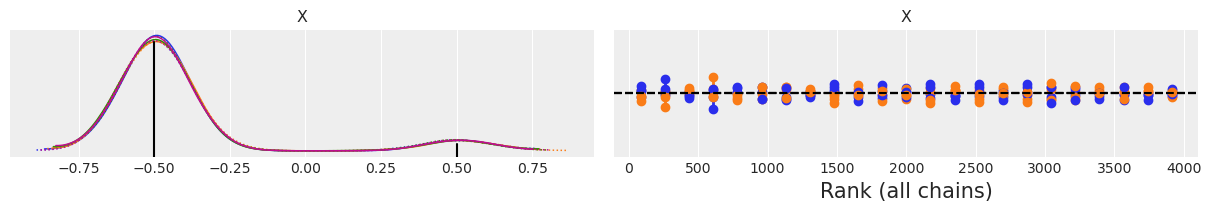

In [5]:
ax = az.plot_trace(az_trace, compact=True, kind="rank_vlines")
ax[0, 0].axvline(-0.5, 0, 0.9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k");

From the KDE we can see that we recover the modes and even the relative weights seems pretty good. The rank plot on the right looks good too. One SMC chain is represented in blue and the other in orange. The vertical lines indicate deviation from the ideal expected value, which is represented with a black dashed line. If a vertical line is above the reference black dashed line we have more samples than expected, if the vertical line is below the sampler is getting less samples than expected. Deviations like the ones in the figure above are fine and not a reason for concern.

As previously said SMC internally computes an estimation of the ESS (from importance weights). Those ESS values are not useful for diagnostics as they are a fixed target value.

We can compute ESS values from the trace returned by `sample_smc`, this is probably an overly optimistic value, as the computation of this ESS value takes autocorrelation into account and each SMC run/chain has low autocorrelation by construction.

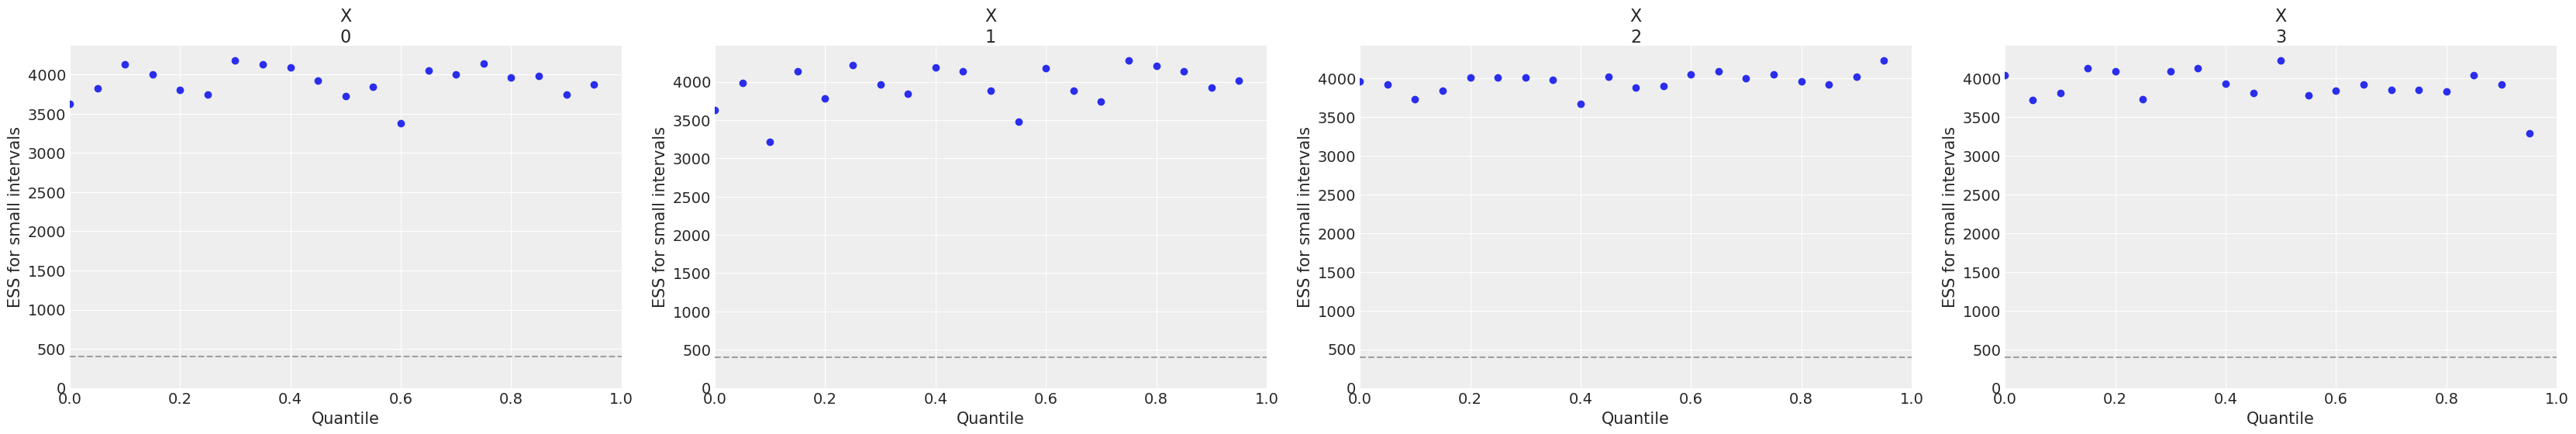

In [6]:
az.plot_ess(az_trace);

## Kill your darlings

SMC (with a Metropolis kernel) is not free of problems, as it relies on Metropolis it will deteriorate as the dimensionality of the problem increases and/or if the geometry of the posterior is _weird_ as in hierarchical models. To some extent increasing the number of draws and maybe the number of `n_steps` could help. To access the number of steps per stage you can check `trace.report.nsteps`. Ideally SMC will take a number of steps lower than `n_steps`.

Let's make SMC fails spectacularly. We will run the same model as before, but increasing the dimensionality from 4 to 40.

In [7]:
n = 40

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1
w2 = 1 - w1

In [8]:
def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])


with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    llk = pm.Potential("llk", two_gaussians(X))
    trace = pm.sample_smc(2000, parallel=True)
    az_trace = az.from_pymc3(trace)

Initializing SMC sampler...
Multiprocess sampling (2 chains in 2 jobs)
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.006
Stage:   3 Beta: 0.009
Stage:   4 Beta: 0.012
Stage:   5 Beta: 0.017
Stage:   6 Beta: 0.021
Stage:   7 Beta: 0.027
Stage:   8 Beta: 0.034
Stage:   9 Beta: 0.042
Stage:  10 Beta: 0.052
Stage:  11 Beta: 0.064
Stage:  12 Beta: 0.078
Stage:  13 Beta: 0.097
Stage:  14 Beta: 0.122
Stage:  15 Beta: 0.152
Stage:  16 Beta: 0.191
Stage:  17 Beta: 0.240
Stage:  18 Beta: 0.301
Stage:  19 Beta: 0.373
Stage:  20 Beta: 0.462
Stage:  21 Beta: 0.566
Stage:  22 Beta: 0.693
Stage:  23 Beta: 0.854
Stage:  24 Beta: 1.000


We see that SMC recognizes this is a harder problem and increases the number of stages. Unfortunately in this case that is not enough to recover the correct posterior as we can see in the following plot. 

Compare this rank plot with the one obtained in the previous example (n=4). The rank plot is telling us that the _blue chain_ is sampling an excess of low parameter values (ranks below 2000) and is failing to sample from high parameter values. The orange-chain is doing the exact opposite. So basically one SMC chain is exploring one mode and the other SMC chain the other, they are failing to mix and to recover the relative weights of each mode.

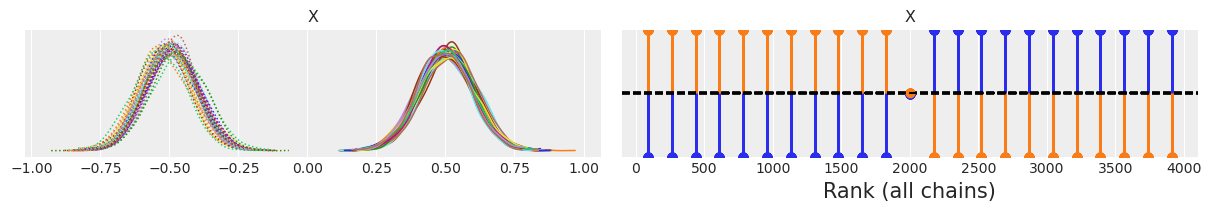

In [9]:
az.plot_trace(az_trace, compact=True, kind="rank_vlines");

Even when each SMC run has low autocorrelation by construction the ESS value computed by ArviZ may under some circumstances show problems. This example is such a case, here each SMC chain is basically exploring a single mode and missing the other. When this happens the value of ESS_bulk (computed using `az.summary` or `az.ess`) will be close to the number of modes, for this problem we got ~3. We are working on providing an ESS estimation better tailored to the peculiarities of SMC.

As the ESS value may vary across the parameter space. We also recommend to check the behavior of localized version of ESS. We can do this with `plot_ess`. The recommended value for ESS is at least 400 (dashed gray line).

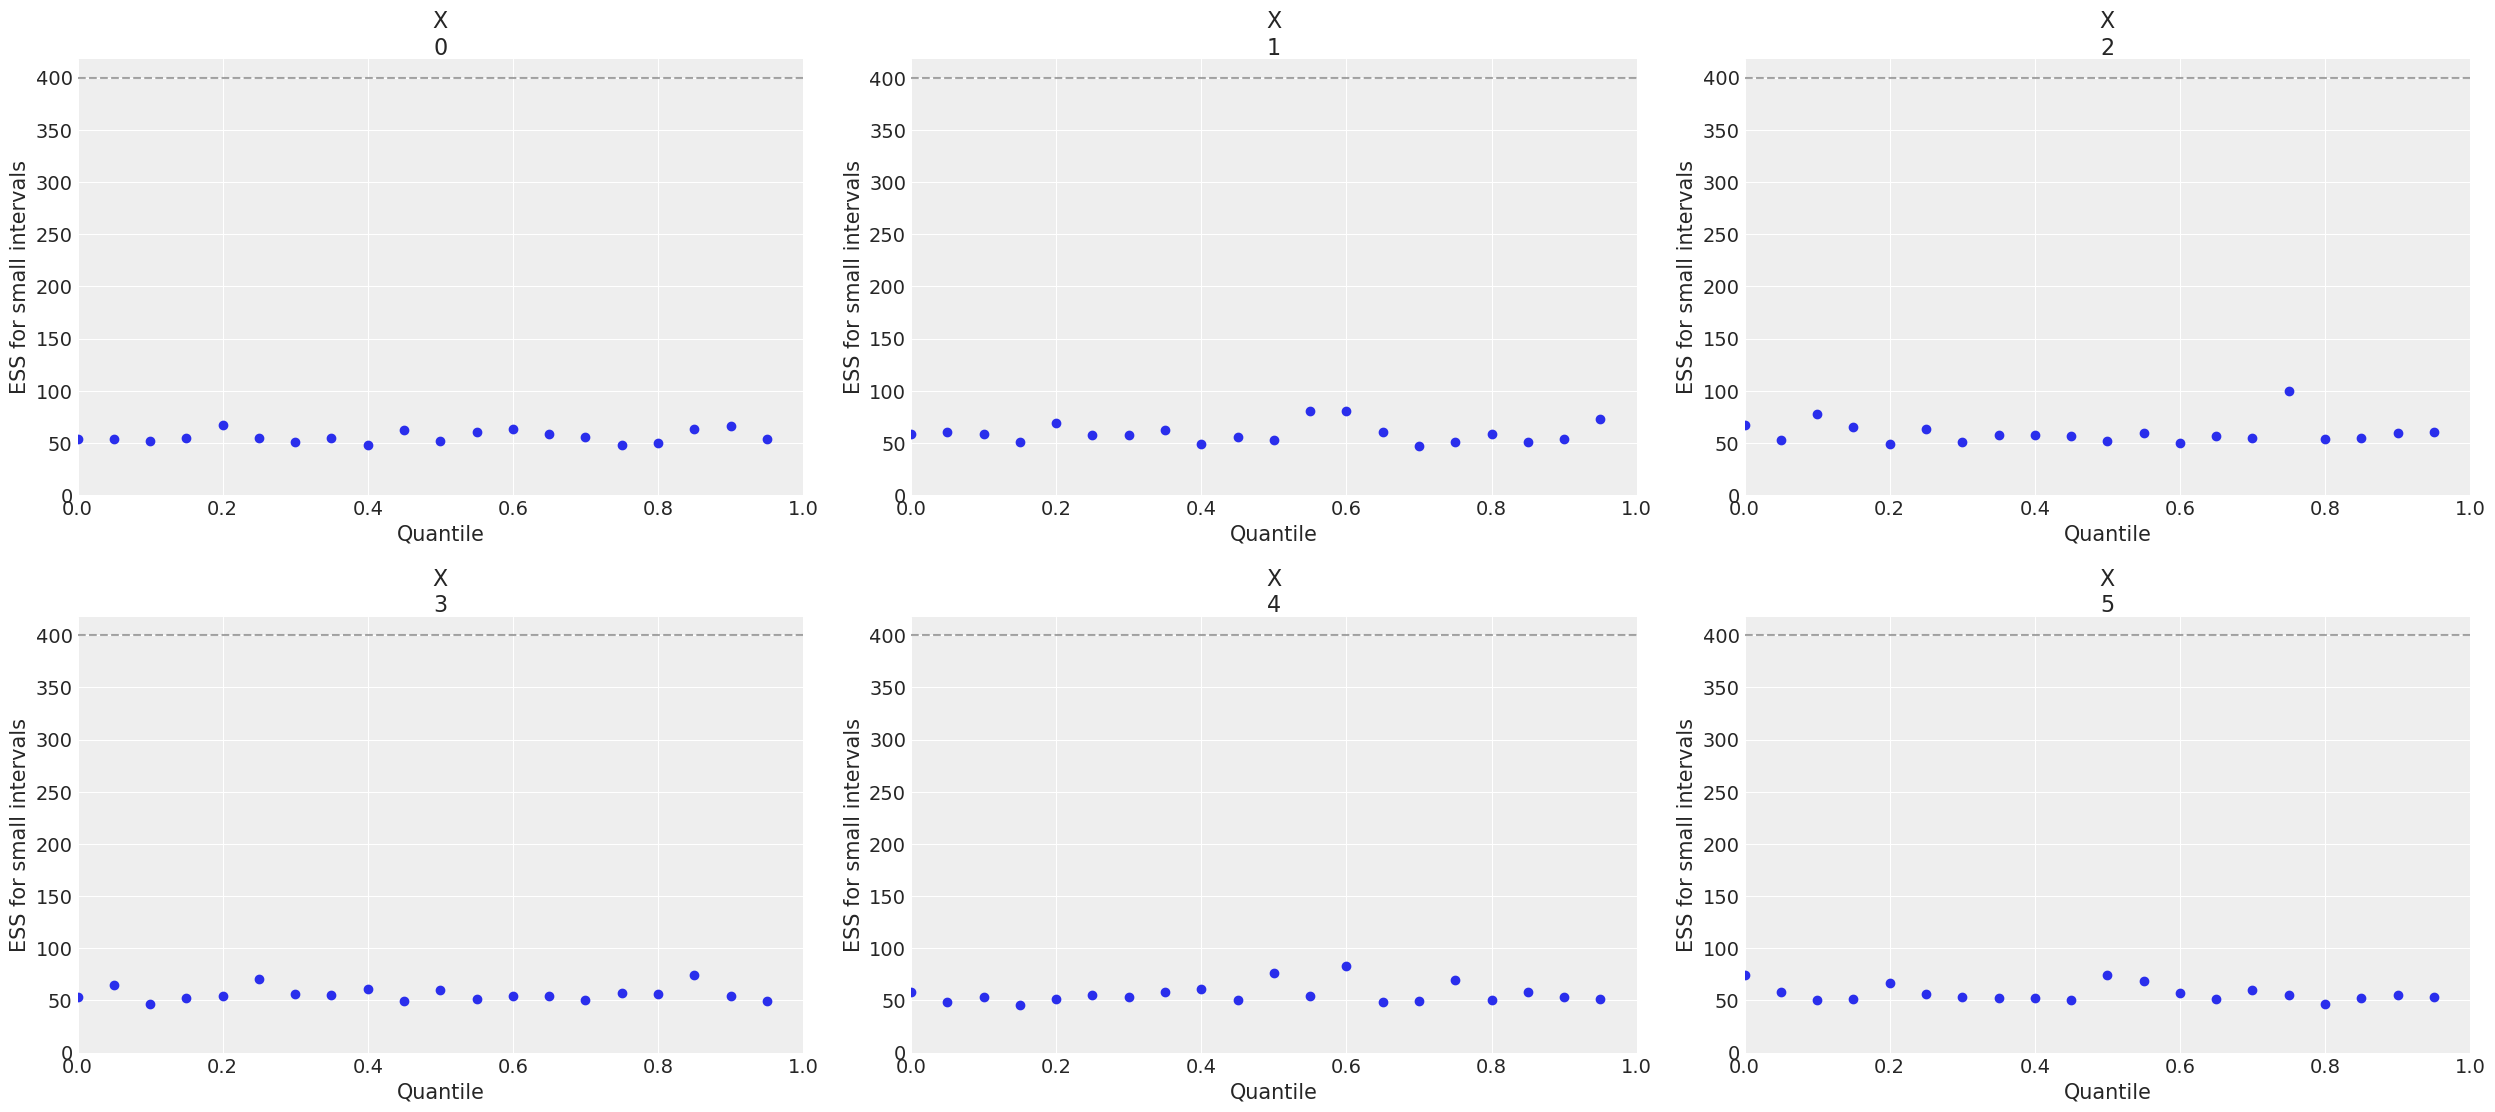

In [10]:
az.plot_ess(az_trace, coords={"X_dim_0": slice(0, 5)});  # only the first 6 dimensions

You may want to repeat the SMC sampling with the failing model as you may get different problems each time.

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

arviz    0.8.3
numpy    1.18.1
autopep8 1.5
json     2.0.9
pymc3    3.9.1
last updated: Mon Jun 29 2020 

CPython 3.7.6
IPython 7.12.0
watermark 2.0.2
